In [10]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import os,sys
import io
from PIL import Image
import tensorflow as tf
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow.io as tfio
from glob import glob
import time
import datetime

%load_ext autoreload
%autoreload 2

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

#https://www.tensorflow.org/tutorials/images/segmentation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensorflow ver. 2.7.0


In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

## Creating our Dataloader

In [12]:
SEED = 42

dataset_path = "training/" 
training_data = "images/"
val_data = "test_set_images/"

# Image size that we are going to use
IMG_SIZE = 400
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 150 classes + `not labeled`
N_CLASSES = 2

In [13]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(dataset_path + training_data + "*.png")


Groundtruth_SIZE = len(glob(dataset_path + "groundtruth/" + "*.png"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(dataset_path + training_data + "*.png")



VALSET_SIZE = len(glob(val_data + "*.png"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")


The Training Dataset contains 100 images.
training/images/*.png
The Training Dataset contains 100 images.
training/images/*.png
The Validation Dataset contains 50 images.


In [14]:
from helper_unet import parse_image

train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.png", seed=SEED)
train_dataset = train_dataset.map(parse_image)
print(len(train_dataset))

val_dataset = tf.data.Dataset.list_files(val_data + "*.png", seed=SEED)
val_dataset =val_dataset.map(parse_image)
print(len(val_dataset))

100
50


## Applying some transformations to our dataset

In [57]:
from helper_unet import load_image_test, load_image_train

BATCH_SIZE = 32

BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
#dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
#dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
#dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
#dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])


<BatchDataset shapes: ((None, 400, 400, 3), (None, 400, 400, 1)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 400, 400, 3), (None, 400, 400, 1)), types: (tf.float32, tf.float32)>


##  Visualizing the Dataset

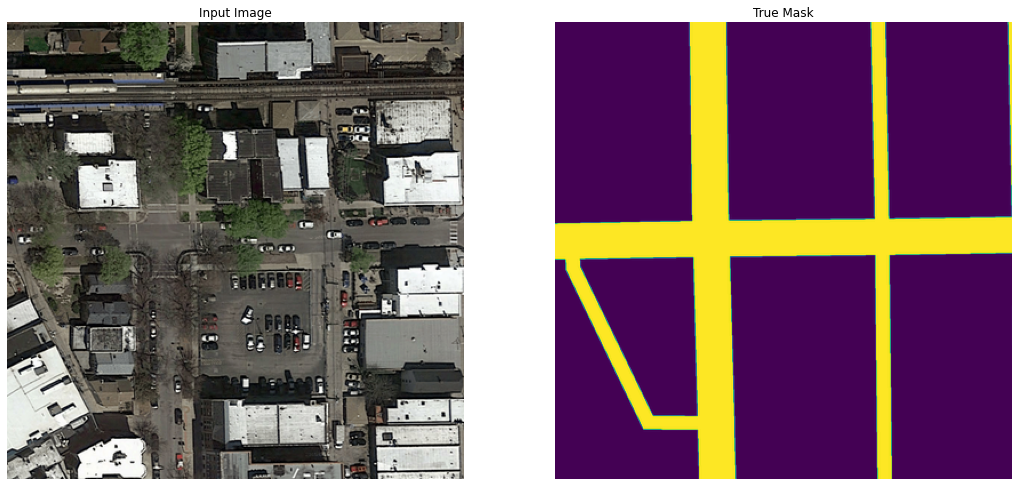

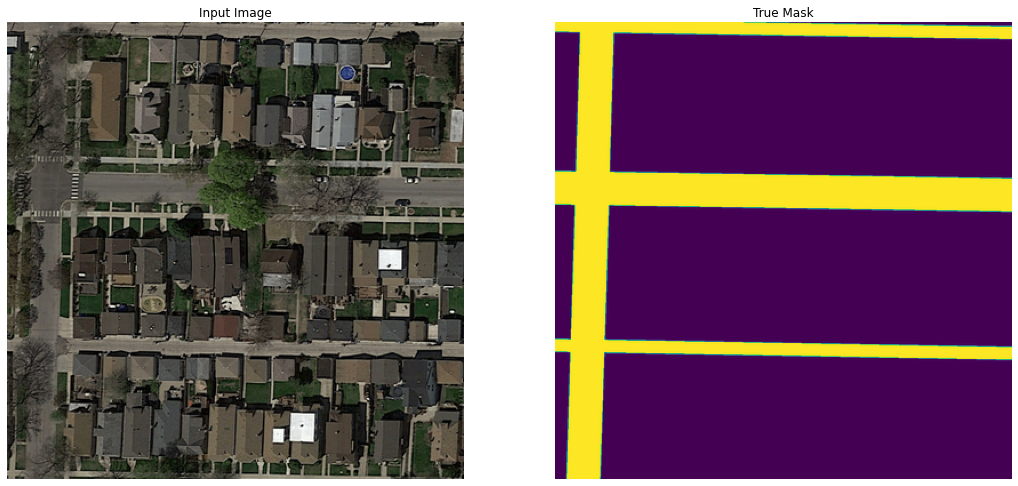

In [58]:
from helper_unet import display_sample

for image, mask in dataset['train'].take(2):
    sample_image, sample_mask = image, mask
    display_sample([sample_image[0], sample_mask[0]])


## Developing the Model (UNet) Using Keras Functional API


In [84]:
#https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47
class UNET_(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.bn  = tf.keras.layers.BatchNormalization()
        self.maxpool= tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)
        
        #Encode
        #struct 1 
        self.conv1= tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, kernel_initializer = 'he_normal' , activation='relu', padding = 'same') 
        
        #struct 2
        self.conv2= tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, kernel_initializer = 'he_normal', activation='relu', padding = 'same') 

        #Struct 3
        self.conv3= tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, kernel_initializer = 'he_normal', activation='relu', padding = 'same') 

        #Struct 4
        self.conv4= tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, kernel_initializer = 'he_normal', activation='relu', padding = 'same') 

        #Struct 5
        self.conv5= tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, kernel_initializer = 'he_normal', activation='relu', padding = 'same') 

        #Decode
        # struct 6
        self.convT6=tf.keras.layers.Conv2DTranspose(filters= 128 , kernel_size = 3, padding = 'same')
        self.conv6= tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation='relu', padding = 'same') 

        # struct 7
        self.convT7=tf.keras.layers.Conv2DTranspose(filters= 64 , kernel_size = 3, padding = 'same')
        self.conv7= tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation='relu', padding = 'same') 

        # struct 8
        self.convT8=tf.keras.layers.Conv2DTranspose(filters= 32 , kernel_size = 3, padding = 'same')
        self.conv8= tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu', padding = 'same') 

        # struct 9
        self.convT9=tf.keras.layers.Conv2DTranspose(filters= 16 , kernel_size = 3, padding = 'same')
        self.conv9= tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, activation='relu', padding = 'same') 

        #output

        self.output_ = tf.keras.layers.Conv2D(filters=1 ,kernel_size =1, activation = 'sigmoid')

    def call(self, inputs):
    #Encode
    # struct 1 
        c1 = self.conv1(inputs)
        c1 = self.bn(c1)
        c1 = self.conv1(c1)
        c1 = self.bn(c1)
        m1= self.maxpool(c1)

    # struct 2
        c2= self.conv2(m1)
        c2 = self.bn(c2)
        m2= self.maxpool(c2)

    # struct 3
        c3= self.conv3(m2)
        c3= self.bn(c3)
        m3= self.maxpool(c3)

    # struct 4
        c4= self.conv4(m3)
        c4= self.bn(c4)
        m4= self.maxpool(c4)
    
    # struct 5
        c5= self.conv5(m4)
        c5 = self.bn(c5)
    #Decode
    # struct 6
        c6 = self.convT6(c5)
        c6 = self.bn(c6)
        c6 =tf.keras.layers.concatenate([c6, c4])
        c6 = self.conv6(c6)

    # struct 7
        c7 = self.convT7(c6)
        c7= self.bn(c7)
        c7 =tf.keras.layers.concatenate([c7, c3])
        c7 = self.conv7(c7)
    
    # struct 8
        c8 = self.convT8(c7)
        c8= self.bn(c8)
        c8 =tf.keras.layers.concatenate([c8, c2])
        c8 = self.conv8(c8)

    # struct 9
        c9 = self.convT9(c8)
        c9= self.bn(c9)
        c9 =tf.keras.layers.concatenate([c9, c1])
        c9 = self.conv9(c9)
    
    #output 
        out= self.output_(c9)
        
        return out

In [85]:
from helper_unet import create_mask, show_predictions
inputs = tf.keras.layers.Input((400,400,3))
outputs = tf.keras.layers.Input((400,400,3))

unet_model= UNET_()


unet_model.compile( loss  = tf.keras.losses.CategoricalCrossentropy(),
metrics   = tf.keras.metrics.CategoricalAccuracy(),
optimizer = tf.keras.optimizers.Adam())



# fit 
#unet_model.fit(x_train, y_train, batch_size=128, epochs=1)

In [86]:
for image, mask in dataset['train'].take(1):
    pred_mask = unet_model.predict(image)
    display_sample([image[0], true_mask, create_mask(pred_mask)])




#for image, mask in dataset['train'].take(1):
    #sample_image, sample_mask = image, mask
    #show_predictions()

ValueError: in user code:

    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "unet__11" (type UNET_).
    
    in user code:
    
        File "/var/folders/0v/8h7cq3md6w90ws4c4y9fsbkr0000gn/T/ipykernel_5640/2250256197.py", line 51, in call  *
            c1 = self.conv1(c1)
        File "/usr/local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/usr/local/lib/python3.9/site-packages/keras/engine/input_spec.py", line 247, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "conv2d_145" is incompatible with the layer: expected axis -1of input shape to have value 3, but received input with shape (32, 400, 400, 16)
    
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(32, 400, 400, 3), dtype=float32)
